# "Taps aff"
"Taps aff" is a Scottish expression that literally means "tops off". It refers to the act of removing one's shirt, typically by men, in warm weather. This phrase is commonly used in Scotland, particularly in Glasgow, to describe good weather or good times being had. The expression is often used humorously, as it's a phenomenon rarely seen in Glasgow due to its typically cool climate. When someone declares "taps aff," it usually indicates that the weather is unusually warm or that a celebratory atmosphere is present.


Objective
*   Develop a deep learning system that predicts whether a day in Glasgow is a "taps aff" day based on weather data.
*   Glasgow weather dataset: https://drive.google.com/file/d/16O9Zoo8npYXQqniAB7K2K40Tlkr3ozSQ/view?usp=sharing Credit: https://open-meteo.com/
*   Taps aff dataset: https://drive.google.com/file/d/1XVNe0XmS-_-umhNwQUVMi3xE04nGKx1R/view?usp=sharing


Top Tips

1.   Implement a regression deep learning model to estimate missing Glasgow weather parameters. Train the regression model on complete data points, then use the trained model to fill in missing values.
2.   Feature engineer the date into day and month to help predict these missing values.
3.   Merge the two datasets by changing dates in the taps aff dataset into the same format as the weather dataset.
4.   Implement a binary classification (use softmax and sparse_categorical_crossentropy) deep learning model to predict the taps aff days from 2023 to 2025.
5.   Use test sets on both the regression and classification to evaluate their performance.


## Load and explore Glasgow weather data


In [ ]:
# Read in glasgow weather and explore
import pandas as pd
df_weather = pd.read_csv('/content/sample_data/glasgow_weather.csv')

In [ ]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7320 entries, 0 to 7319
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   date                         7320 non-null   object 
 1   temperature_2m_mean          7320 non-null   float64
 2   daylight_duration            6590 non-null   float64
 3   precipitation_sum            7320 non-null   float64
 4   wind_speed_10m_max           7320 non-null   float64
 5   wind_direction_10m_dominant  7320 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 343.3+ KB


In [ ]:
df_weather.head()

,date,temperature_2m_mean,daylight_duration,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant
0,2005-01-06,7.3,NaN,0.197,22.3,219
1,2005-01-07,9.1,NaN,0.839,24.1,222
2,2005-01-08,4.4,NaN,1.020,27.0,249
3,2005-01-09,7.6,NaN,0.713,22.1,211
4,2005-01-10,8.4,NaN,0.161,24.8,231


In [ ]:
df_weather.tail()

,date,temperature_2m_mean,daylight_duration,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant
7315,2025-01-16,7.4,27737.29,0.000,12.2,215
7316,2025-01-17,8.8,27927.04,0.012,12.0,208
7317,2025-01-18,7.2,28121.36,0.000,8.5,193
7318,2025-01-19,5.2,28319.92,0.000,5.5,157
7319,2025-01-20,6.6,28522.41,0.008,5.9,212


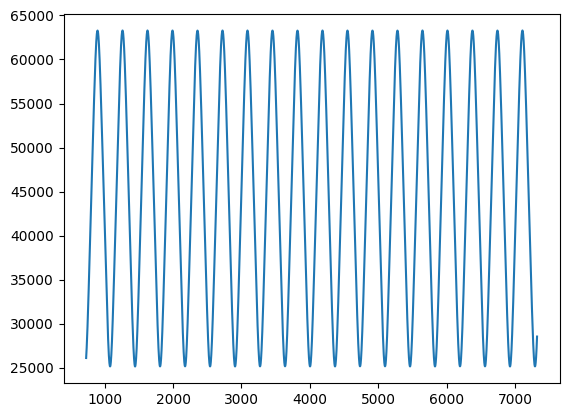

In [ ]:
# Look at missing daylight_duration
import matplotlib.pyplot as plt
plt.plot(df_weather['daylight_duration'])

In [ ]:
# Create two new features to help make a model to replace missing daylight_duration
# Feature engineering: extract *day* and *month* from the date string
# Why: daylight duration is strongly seasonal, so month/day help the regression model learn that pattern
df_weather['day'] = df_weather['date'].apply(lambda x: int(x[8:]))
df_weather['month'] = df_weather['date'].apply(lambda x: int(x[5:7]))
df_weather.head()

,date,temperature_2m_mean,daylight_duration,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,day,month
0,2005-01-06,7.3,NaN,0.197,22.3,219,6,1
1,2005-01-07,9.1,NaN,0.839,24.1,222,7,1
2,2005-01-08,4.4,NaN,1.020,27.0,249,8,1
3,2005-01-09,7.6,NaN,0.713,22.1,211,9,1
4,2005-01-10,8.4,NaN,0.161,24.8,231,10,1


In [ ]:
# Split the dataset into:
# 1) rows WITH missing daylight_duration (used later for prediction)
# 2) rows with KNOWN daylight_duration (used to train the regression model)

# Create to new dataframes - one with missing 730 days of daylight and one without after initial 730 days
df_weather_with_nan = df_weather.iloc[:730]
df_weather_without_nan = df_weather.iloc[730:]

# Alternatively and more elegantly
df_weather_with_nan = df_weather[df_weather['daylight_duration'].isna()]
df_weather_without_nan = df_weather[df_weather['daylight_duration'].notna()]

In [ ]:
# Check that worked
df_weather_with_nan.tail()

,date,temperature_2m_mean,daylight_duration,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,day,month
725,2007-01-01,4.4,NaN,0.260,21.3,253,1,1
726,2007-01-02,5.0,NaN,0.091,15.8,254,2,1
727,2007-01-03,8.4,NaN,0.445,21.6,216,3,1
728,2007-01-04,7.6,NaN,0.087,22.5,266,4,1
729,2007-01-05,7.1,NaN,0.217,19.0,234,5,1


In [ ]:
# Check that worked
df_weather_without_nan.head()

,date,temperature_2m_mean,daylight_duration,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,day,month
730,2007-01-06,6.2,26084.80,0.083,17.7,218,6,1
731,2007-01-07,7.0,26210.93,0.650,18.5,228,7,1
732,2007-01-08,6.3,26344.22,0.311,20.5,221,8,1
733,2007-01-09,7.8,26484.33,0.480,25.8,234,9,1
734,2007-01-10,4.1,26630.95,0.161,25.0,227,10,1


In [ ]:
# Create training arrays for regression
# X = input features (all columns except the target and raw date string)
# y = target value to predict (daylight_duration)
x = df_weather_without_nan.drop(['daylight_duration','date'], axis=1).to_numpy()
y = df_weather_without_nan[['daylight_duration']].to_numpy()
print(x.shape)
print(y.shape)

(6590, 6)
(6590, 1)


In [ ]:
# Training and testing sets
boundary = int(x.shape[0] * 0.8)
x_train = x[:boundary]
y_train = y[:boundary]
x_test = x[boundary:]
y_test = y[boundary:]

In [ ]:
# Standardise inputs using TRAINING statistics only (prevents data leakage)
# Standardisation helps neural networks train more smoothly when features are on similar scales
means = x_train.mean(axis=0)
stds = x_train.std(axis=0)
x_train = (x_train - means) / stds

# And test set with values from training set
x_test = (x_test - means) / stds

## Regression model to impute missing `daylight_duration`


In [ ]:
from tensorflow import keras

# Regression model (deep network with residual blocks)
# Goal: learn a mapping from weather/date features -> daylight_duration
# Residual connections help deeper networks train by providing a "shortcut" path for gradients

# Input block
inputs = keras.layers.Input(shape=(6,))
z = inputs

# Projection layer
z = keras.layers.Dense(128)(z)

# Two blocks
for i in range(2):
  # Residual connection (ensemble like)
  res = z

  # Layer norm
  z = keras.layers.LayerNormalization()(z)

  # Inverted bottleneck (dimension reduction)
  z = keras.layers.Dense(4*128)(z)
  z = keras.activations.gelu(z) # probabilistic interpretation of dropout (ie ensemble like)
  z = keras.layers.Dense(128)(z)

  # Residual connection
  z = keras.layers.Add()([res,z])

# Layer norm
z = keras.layers.LayerNormalization()(z)

# Regression output block
z = keras.layers.Dense(1)(z)
outputs = keras.activations.gelu(z)

In [ ]:
# Prepare model
model = keras.Model(inputs=[inputs], outputs=[outputs])
model.summary()
model.compile(
  loss=keras.losses.MeanSquaredError(),
  optimizer=keras.optimizers.Adam(learning_rate=keras.optimizers.schedules.CosineDecay(initial_learning_rate=0.01, decay_steps=30*165)) # cosine annealing to help converge
)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 128)       │        896 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128)       │        256 │ dense_18[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 512)       │     66,048 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gelu_8 (Gelu)       │ (None, 512)       │          0 │ dense_19[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 128)       │     65,664 │ gelu_8[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 128)       │          0 │ dense_18[0][0],   │
│                     │                   │            │ dense_20[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128)       │        256 │ add_6[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 512)       │     66,048 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gelu_9 (Gelu)       │ (None, 512)       │          0 │ dense_21[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 128)       │     65,664 │ gelu_9[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_7 (Add)         │ (None, 128)       │          0 │ add_6[0][0],      │
│                     │                   │            │ dense_22[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128)       │        256 │ add_7[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 1)         │        129 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gelu_10 (Gelu)      │ (None, 1)         │          0 │ dense_23[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 265,217 (1.01 MB)

 Trainable params: 265,217 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train model
model.fit(x_train, y_train, epochs=30)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_45']
Received: inputs=Tensor(shape=(None, 6))
  warnings.warn(msg)


165/165 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 2146136192.0000
Epoch 2/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1897836928.0000
Epoch 3/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 1451580800.0000
Epoch 4/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 952661184.0000
Epoch 5/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 545933824.0000
Epoch 6/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 306742656.0000
Epoch 7/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 184419136.0000
Epoch 8/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 110389008.0000
Epoch 9/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 50948200.0000
Epoch 10/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 25808764.0000
Epoch 11/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 14415195.0000
Epoch 12/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 8667363.0000
Epoch 13/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4836172.5000
Epoch 14/30
165/165 ━━━━━━━━━━━━━━

In [ ]:
# Performance on test set
model.evaluate(x_test, y_test)

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 201538.4375


141419.21875

In [ ]:
# Prepare for inference and replacing missing values
x = df_weather_with_nan.drop(['daylight_duration','date'], axis=1).to_numpy()
print(x.shape)

(730, 6)


In [ ]:
# Standardise the input with above values
x = (x - means) / stds

In [ ]:
# Infer
y_pred = model.predict(x)
print(y_pred)

 1/23 ━━━━━━━━━━━━━━━━━━━━ 3s 181ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_45']
Received: inputs=Tensor(shape=(32, 6))
  warnings.warn(msg)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_45']
Received: inputs=Tensor(shape=(None, 6))
  warnings.warn(msg)


[[26143.688]
 [26240.568]
 [26293.604]
 [26529.451]
 [26687.654]
 [26828.701]
 [26955.34 ]
 [27149.479]
 [27351.967]
 [27505.002]
 [27690.627]
 [27827.074]
 [28006.89 ]
 [28204.018]
 [28380.453]
 [28600.518]
 [28829.115]
 [29003.258]
 [29216.295]
 [29447.611]
 [29684.365]
 [29907.834]
 [30152.725]
 [30411.107]
 [30647.912]
 [30865.361]
 [31127.332]
 [31350.633]
 [31611.666]
 [31839.229]
 [32072.748]
 [32365.291]
 [32596.52 ]
 [32816.707]
 [33073.35 ]
 [33368.426]
 [33611.594]
 [33880.844]
 [34179.566]
 [34435.24 ]
 [34720.523]
 [34938.816]
 [35251.094]
 [35531.65 ]
 [35822.363]
 [36133.36 ]
 [36374.5  ]
 [36624.26 ]
 [36887.45 ]
 [37167.09 ]
 [37446.99 ]
 [37761.742]
 [38048.64 ]
 [38230.105]
 [38801.914]
 [39024.81 ]
 [39077.527]
 [39428.12 ]
 [39760.176]
 [39961.027]
 [40281.66 ]
 [40601.152]
 [40856.414]
 [41058.95 ]
 [41355.156]
 [41689.504]
 [41949.77 ]
 [42253.55 ]
 [42480.293]
 [42733.074]
 [43035.543]
 [43316.96 ]
 [43597.715]
 [43860.184]
 [44123.785]
 [44347.78 ]
 [44654.246]

In [ ]:
# Column 2 is where missing values are
df_weather.head()

,date,temperature_2m_mean,daylight_duration,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,day,month
0,2005-01-06,7.3,NaN,0.197,22.3,219,6,1
1,2005-01-07,9.1,NaN,0.839,24.1,222,7,1
2,2005-01-08,4.4,NaN,1.020,27.0,249,8,1
3,2005-01-09,7.6,NaN,0.713,22.1,211,9,1
4,2005-01-10,8.4,NaN,0.161,24.8,231,10,1


In [ ]:
# Replace the column 2 values (first 730) with the model predictions
# df_weather.iloc[:730, 2] = y_pred

# Alternatively and more elegantly
df_weather.loc[df_weather['daylight_duration'].isna(), 'daylight_duration'] = y_pred


df_weather.head()

,date,temperature_2m_mean,daylight_duration,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,day,month
0,2005-01-06,7.3,26143.687500,0.197,22.3,219,6,1
1,2005-01-07,9.1,26240.568359,0.839,24.1,222,7,1
2,2005-01-08,4.4,26293.603516,1.020,27.0,249,8,1
3,2005-01-09,7.6,26529.451172,0.713,22.1,211,9,1
4,2005-01-10,8.4,26687.654297,0.161,24.8,231,10,1


## Read and explore "taps aff" data


In [ ]:
df_taps_aff = pd.read_csv('/content/sample_data/taps_aff.csv')

In [ ]:
df_taps_aff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6590 entries, 0 to 6589
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   date     6590 non-null   object
 1   tap_aff  6590 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 58.0+ KB


In [ ]:
df_taps_aff.head()

,date,tap_aff
0,06/01/2005,False
1,07/01/2005,False
2,08/01/2005,False
3,09/01/2005,False
4,10/01/2005,False


In [ ]:
df_taps_aff.tail()

,date,tap_aff
6585,17/01/2023,False
6586,18/01/2023,False
6587,19/01/2023,False
6588,20/01/2023,False
6589,21/01/2023,False


In [ ]:
# Change date format into same as weather dataset
df_taps_aff['date'] = df_taps_aff['date'].apply(lambda x: x[6:] + "-" + x[3:5] + "-" + x[:2])
df_taps_aff.head()

,date,tap_aff
0,2005-01-06,False
1,2005-01-07,False
2,2005-01-08,False
3,2005-01-09,False
4,2005-01-10,False


In [ ]:
df_taps_aff.tail()

,date,tap_aff
6585,2023-01-17,False
6586,2023-01-18,False
6587,2023-01-19,False
6588,2023-01-20,False
6589,2023-01-21,False


## Join two dataframes together


In [ ]:
df_joined = df_weather.merge(df_taps_aff, on='date', how='left')


In [ ]:
# Check that worked
df_joined.head()

,date,temperature_2m_mean,daylight_duration,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,day,month,tap_aff
0,2005-01-06,7.3,26143.687500,0.197,22.3,219,6,1,False
1,2005-01-07,9.1,26240.568359,0.839,24.1,222,7,1,False
2,2005-01-08,4.4,26293.603516,1.020,27.0,249,8,1,False
3,2005-01-09,7.6,26529.451172,0.713,22.1,211,9,1,False
4,2005-01-10,8.4,26687.654297,0.161,24.8,231,10,1,False


In [ ]:
# Check that worked
df_joined.tail()

,date,temperature_2m_mean,daylight_duration,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,day,month,tap_aff
7315,2025-01-16,7.4,27737.29,0.000,12.2,215,16,1,NaN
7316,2025-01-17,8.8,27927.04,0.012,12.0,208,17,1,NaN
7317,2025-01-18,7.2,28121.36,0.000,8.5,193,18,1,NaN
7318,2025-01-19,5.2,28319.92,0.000,5.5,157,19,1,NaN
7319,2025-01-20,6.6,28522.41,0.008,5.9,212,20,1,NaN


In [ ]:
# Create two new dataframes - one with missing 730 days of taps aff and one without before the final 730 days
df_joined_with_nan = df_joined.iloc[-730:]
df_joined_without_nan = df_joined.iloc[:-730]

# Alternatively and more elegantly
df_joined_with_nan = df_joined[df_joined['tap_aff'].isna()]
df_joined_without_nan = df_joined[df_joined['tap_aff'].notna()]

In [ ]:
# Check that worked
df_joined_without_nan.tail()

,date,temperature_2m_mean,daylight_duration,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,day,month,tap_aff
6585,2023-01-17,-1.0,27822.05,0.000,10.0,262,17,1,False
6586,2023-01-18,0.4,28006.37,0.000,9.0,281,18,1,False
6587,2023-01-19,0.6,28196.92,0.000,13.4,266,19,1,False
6588,2023-01-20,-0.4,28393.68,0.000,6.2,130,20,1,False
6589,2023-01-21,2.0,28596.23,0.051,10.5,160,21,1,False


In [ ]:
# Check that worked
df_joined_with_nan.head()

,date,temperature_2m_mean,daylight_duration,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,day,month,tap_aff
6590,2023-01-22,6.9,28804.18,0.114,11.9,188,22,1,NaN
6591,2023-01-23,8.5,29017.13,0.043,9.1,207,23,1,NaN
6592,2023-01-24,8.7,29234.71,0.012,9.9,226,24,1,NaN
6593,2023-01-25,7.1,29456.55,0.055,14.4,256,25,1,NaN
6594,2023-01-26,2.5,29682.30,0.000,6.1,316,26,1,NaN


In [ ]:
# Build classification arrays
# X = input features (weather + engineered date features)
# y = binary label (tap_aff). Convert boolean to int (0/1) for training
x = df_joined_without_nan.drop(['tap_aff','date'], axis=1).to_numpy()
y = df_joined_without_nan[['tap_aff']].to_numpy(dtype='int8') # convert from bool to int
print(x.shape)
print(y.shape)

(6590, 7)
(6590, 1)


In [ ]:
# Training and testing sets
boundary = int(x.shape[0] * 0.8)
x_train = x[:boundary]
y_train = y[:boundary]
x_test = x[boundary:]
y_test = y[boundary:]

In [ ]:
# Standardise training set
means = x_train.mean(axis=0)
stds = x_train.std(axis=0)
x_train = (x_train - means) / stds

# And test set with values from training set
x_test = (x_test - means) / stds

## Binary classification model: predict “taps aff” days


In [ ]:
# Binary classification model (deep network with residual blocks)
# Goal: predict tap_aff (0/1) from weather features

# Input block
inputs = keras.layers.Input(shape=(7,))
z = inputs

# Projection layer
z = keras.layers.Dense(128)(z)

# Two blocks
for i in range(2):
  # Residual connection (ensemble like)
  res = z

  # Layer norm
  z = keras.layers.LayerNormalization()(z)

  # Inverted bottleneck (dimension reduction)
  z = keras.layers.Dense(4*128)(z)
  z = keras.activations.gelu(z) # probabilistic interpretation of dropout (ie ensemble like)
  z = keras.layers.Dense(128)(z)

  # Residual connection
  z = keras.layers.Add()([res,z])

# Layer norm
z = keras.layers.LayerNormalization()(z)

# Sigmoid output block
z = keras.layers.Dense(1)(z)
outputs = keras.activations.sigmoid(z)

In [ ]:
# Prepare model
model = keras.Model(inputs=[inputs], outputs=[outputs])
model.summary()
model.compile(
  loss=keras.losses.BinaryCrossentropy(),
  optimizer=keras.optimizers.Adam(learning_rate=keras.optimizers.schedules.CosineDecay(initial_learning_rate=0.01, decay_steps=30*165)) # cosine annealing to help converge
)

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 7)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 128)       │      1,024 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128)       │        256 │ dense_24[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 512)       │     66,048 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gelu_11 (Gelu)      │ (None, 512)       │          0 │ dense_25[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 128)       │     65,664 │ gelu_11[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 128)       │          0 │ dense_24[0][0],   │
│                     │                   │            │ dense_26[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128)       │        256 │ add_8[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_27 (Dense)    │ (None, 512)       │     66,048 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gelu_12 (Gelu)      │ (None, 512)       │          0 │ dense_27[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 128)       │     65,664 │ gelu_12[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 128)       │          0 │ add_8[0][0],      │
│                     │                   │            │ dense_28[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128)       │        256 │ add_9[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_29 (Dense)    │ (None, 1)         │        129 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sigmoid_1 (Sigmoid) │ (None, 1)         │          0 │ dense_29[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 265,345 (1.01 MB)

 Trainable params: 265,345 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train model
model.fit(x_train, y_train, epochs=30)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_60']
Received: inputs=Tensor(shape=(None, 7))
  warnings.warn(msg)


165/165 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.2706
Epoch 2/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0453
Epoch 3/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0414
Epoch 4/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0471
Epoch 5/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0386
Epoch 6/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0361
Epoch 7/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0376
Epoch 8/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0333
Epoch 9/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0347
Epoch 10/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0348
Epoch 11/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0305
Epoch 12/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0278
Epoch 13/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0221
Epoch 14/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0167
Epoch 15/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0

In [ ]:
# Performance on test set
model.evaluate(x_test, y_test)

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0051


0.008026475086808205

In [ ]:
# Prepare for inference and replacing missing values
x = df_joined_with_nan.drop(['tap_aff','date'], axis=1).to_numpy()
print(x.shape)

(730, 7)


In [ ]:
# Standardise the input with above values
x = (x - means) / stds

In [ ]:
# Infer
y_pred = model.predict(x)

import numpy as np
print(np.round(y_pred)) # np.round to convert simoid predictions to 0/1 false/true values

 1/23 ━━━━━━━━━━━━━━━━━━━━ 3s 176ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_60']
Received: inputs=Tensor(shape=(32, 7))
  warnings.warn(msg)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_60']
Received: inputs=Tensor(shape=(None, 7))
  warnings.warn(msg)


## Conclusion

In this project, I built a deep learning system to predict whether a day in Glasgow is a “taps aff” day based on weather data.
I used a regression model to estimate missing weather values and then trained a binary classification model to detect warm days.
The model learned meaningful seasonal patterns, such as longer daylight in summer and shorter daylight in winter.
This project strengthened my understanding of data preprocessing, feature engineering, missing value handling, and machine learning workflows.
Future improvements could include adding more weather features, tuning hyperparameters, and testing alternative model architectures.
